In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import numpy as np
import io

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

In [2]:
from utils import *
from data import *
from models import *
from train import *

In [3]:
%run data.py
%run utils.py
%run models.py
%run train.py

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Import

In [5]:
data_1lead = import_afc_data()

data_1lead = [x for x in data_1lead if x[1] != '~']

labelmap = {x:i for i,x in enumerate(list(set([x[1] for x in data_1lead])))}

dataset_1lead = WindowDataset(data_1lead, labelmap, device=device)

100%|██████████| 8528/8528 [00:01<00:00, 8010.19it/s]
8528it [00:02, 2891.50it/s]


In [6]:
data_12lead = import_balanced_12lead_data()

dataset_12lead = WindowDataset(data_12lead, labelmap, device=device, trim_samples=1000)

3318it [00:03, 991.74it/s] 


In [7]:
pd.Series([x[1] for x in data_1lead]).value_counts()

N    5076
O    2415
A     758
~     279
Name: count, dtype: int64

In [8]:
pd.Series([x[1] for x in data_12lead]).value_counts()

O    1106
A    1106
N    1106
Name: count, dtype: int64

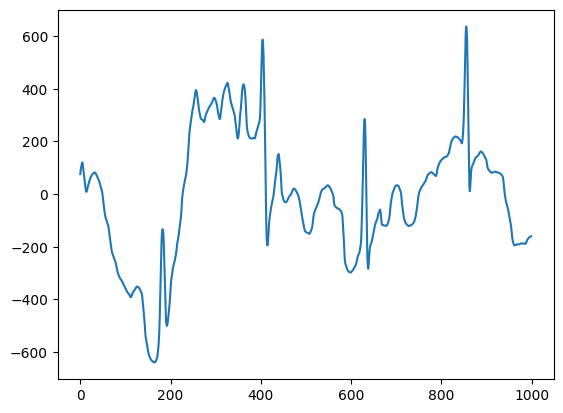

In [9]:
def plotwave(x, n=1000):
    plt.plot(x[:n])

plotwave(data_1lead[19][0])

In [10]:
value_counts = dataset_1lead.get_value_counts()
weights = [sum(value_counts)/x for x in value_counts]
weights[labelmap['~']] = weights[labelmap['N']]

# Training

## Single-Lead Model

Fold 1
Epoch:10/200 AVG Training Loss:3.04077 AVG Test Loss:3.20989 AVG Training Acc 33.51 % AVG Test Acc 35.19 %
Epoch:20/200 AVG Training Loss:2.83364 AVG Test Loss:2.72694 AVG Training Acc 35.84 % AVG Test Acc 39.42 %
Epoch:30/200 AVG Training Loss:2.65929 AVG Test Loss:2.66555 AVG Training Acc 40.09 % AVG Test Acc 41.65 %
Epoch:40/200 AVG Training Loss:2.55458 AVG Test Loss:2.71694 AVG Training Acc 44.18 % AVG Test Acc 45.26 %
Epoch:50/200 AVG Training Loss:2.56486 AVG Test Loss:2.55959 AVG Training Acc 43.45 % AVG Test Acc 46.18 %
Epoch:60/200 AVG Training Loss:2.50853 AVG Test Loss:2.57656 AVG Training Acc 43.37 % AVG Test Acc 46.68 %
Epoch:70/200 AVG Training Loss:2.48687 AVG Test Loss:2.59254 AVG Training Acc 45.97 % AVG Test Acc 72.24 %
Epoch:80/200 AVG Training Loss:2.47688 AVG Test Loss:2.60567 AVG Training Acc 45.15 % AVG Test Acc 47.00 %
Epoch:90/200 AVG Training Loss:2.38100 AVG Test Loss:2.52574 AVG Training Acc 44.18 % AVG Test Acc 47.12 %
Epoch:100/200 AVG Training Los

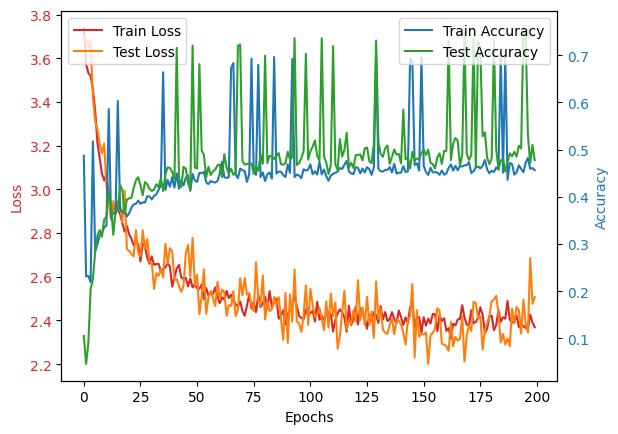

Overall results of 5 fold cross-validation
Train: Average loss 2.3688994822678744, average accuracy 70.17338890343801
Test: Average loss 2.506880223751068, average accuracy 75.76689993442548


In [11]:
## Train k-fold crossvalidated model on 1 lead data

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.lr = 0.002
trainparams.n_epochs = 200

history, confusion_list = train_kfold_model(dataset_1lead, trainparams, test=True)

plot_tt_graph(history, idx=0)
display_results(history,trainparams=trainparams)

In [12]:
def plt_c(cm):
    labelmap2 = {x:y for y,x in labelmap.items()}

    # Converting the confusion matrix to fraction
    cm_fraction = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    print(cm_fraction)

    # Creating a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_fraction, annot=True, fmt=".2f", cmap='Blues', xticklabels=[labelmap2[i] for i in range(4)], yticklabels=[labelmap2[i] for i in range(4)])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix (as fraction)')
    plt.show()

In [15]:
## Build model on entire 1lead dataset and save to buffer

buffer = io.BytesIO()

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.n_epochs = 200

model, history = train_entire_model(dataset_1lead, trainparams)

torch.save(model.state_dict(), buffer)

ValueError: too many values to unpack (expected 2)

## Transfer

Fold 1
Epoch:10/100 AVG Training Loss:0.01017 AVG Test Loss:0.00892 AVG Training Acc 37.76 % AVG Test Acc 37.26 %
Epoch:20/100 AVG Training Loss:0.00995 AVG Test Loss:0.00884 AVG Training Acc 40.48 % AVG Test Acc 43.45 %
Epoch:30/100 AVG Training Loss:0.00989 AVG Test Loss:0.00875 AVG Training Acc 41.39 % AVG Test Acc 46.27 %
Epoch:40/100 AVG Training Loss:0.00946 AVG Test Loss:0.00835 AVG Training Acc 52.27 % AVG Test Acc 57.88 %
Epoch:50/100 AVG Training Loss:0.00835 AVG Test Loss:0.00719 AVG Training Acc 59.21 % AVG Test Acc 61.57 %
Epoch:60/100 AVG Training Loss:0.00745 AVG Test Loss:0.00652 AVG Training Acc 65.26 % AVG Test Acc 64.68 %
Epoch:70/100 AVG Training Loss:0.00642 AVG Test Loss:0.00639 AVG Training Acc 70.39 % AVG Test Acc 66.32 %
Epoch:80/100 AVG Training Loss:0.00571 AVG Test Loss:0.00614 AVG Training Acc 72.51 % AVG Test Acc 67.02 %
Epoch:90/100 AVG Training Loss:0.00518 AVG Test Loss:0.00604 AVG Training Acc 75.83 % AVG Test Acc 67.96 %
Epoch:100/100 AVG Training Los

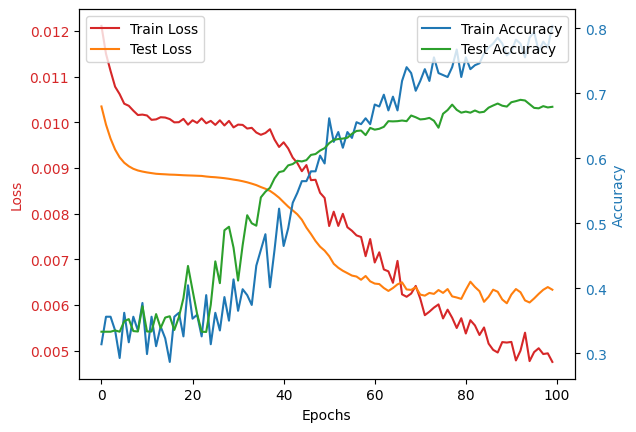

Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.004248916424144556, average accuracy 82.64004659119864
Test: Average loss 0.006476692680809093, average accuracy 68.27073267481256


In [ ]:
## Control training - no transfer
## No inter-channel connections, pure vote model

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.k=10
trainparams.m=9
trainparams.early_stopping=20

history = train_kfold_transfer_model(dataset_12lead, trainparams, TransferFCModel, test=False)

plot_tt_graph(history, idx=0)
display_results(history, trainparams=trainparams)

Fold 1
Epoch:10/100 AVG Training Loss:0.00607 AVG Test Loss:0.00483 AVG Training Acc 73.72 % AVG Test Acc 71.31 %
Epoch:20/100 AVG Training Loss:0.00520 AVG Test Loss:0.00452 AVG Training Acc 80.66 % AVG Test Acc 76.20 %
Epoch:30/100 AVG Training Loss:0.00444 AVG Test Loss:0.00456 AVG Training Acc 86.71 % AVG Test Acc 77.23 %
Epoch:40/100 AVG Training Loss:0.00448 AVG Test Loss:0.00465 AVG Training Acc 87.01 % AVG Test Acc 76.70 %
Epoch:50/100 AVG Training Loss:0.00408 AVG Test Loss:0.00475 AVG Training Acc 89.12 % AVG Test Acc 76.23 %
Early stopping triggered after epoch 54
Fold 2
Epoch:10/100 AVG Training Loss:0.00627 AVG Test Loss:0.00475 AVG Training Acc 74.32 % AVG Test Acc 73.02 %
Epoch:20/100 AVG Training Loss:0.00532 AVG Test Loss:0.00463 AVG Training Acc 80.97 % AVG Test Acc 73.52 %
Epoch:30/100 AVG Training Loss:0.00471 AVG Test Loss:0.00476 AVG Training Acc 84.29 % AVG Test Acc 74.09 %
Epoch:40/100 AVG Training Loss:0.00458 AVG Test Loss:0.00474 AVG Training Acc 86.71 % AVG 

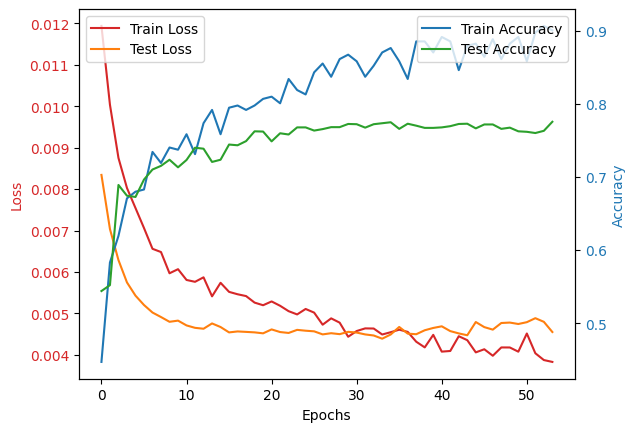

Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.004188566034802732, average accuracy 90.77803661777017
Test: Average loss 0.004769467550075143, average accuracy 76.52196468241146


In [ ]:
## Train 10-fold crossvalidated model transferred, 1 -> 12 lead data
## No inter-channel connections, pure vote model

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.k=10
trainparams.m=9
trainparams.early_stopping=20

history = train_kfold_transfer_model(dataset_12lead, trainparams, TransferFCModel, buffer=buffer, test=False)

plot_tt_graph(history, idx=0)
display_results(history, trainparams=trainparams)

Fold 1
Epoch:10/100 AVG Training Loss:0.01205 AVG Test Loss:0.00549 AVG Training Acc 70.69 % AVG Test Acc 69.20 %
Epoch:20/100 AVG Training Loss:0.01077 AVG Test Loss:0.00493 AVG Training Acc 78.55 % AVG Test Acc 73.89 %
Epoch:30/100 AVG Training Loss:0.01044 AVG Test Loss:0.00476 AVG Training Acc 83.69 % AVG Test Acc 74.26 %
Epoch:40/100 AVG Training Loss:0.01052 AVG Test Loss:0.00469 AVG Training Acc 84.89 % AVG Test Acc 75.19 %
Epoch:50/100 AVG Training Loss:0.01034 AVG Test Loss:0.00476 AVG Training Acc 86.71 % AVG Test Acc 75.06 %
Early stopping triggered after epoch 54
Fold 2
Epoch:10/100 AVG Training Loss:0.01197 AVG Test Loss:0.00556 AVG Training Acc 72.51 % AVG Test Acc 68.87 %
Epoch:20/100 AVG Training Loss:0.01052 AVG Test Loss:0.00483 AVG Training Acc 80.66 % AVG Test Acc 72.98 %
Epoch:30/100 AVG Training Loss:0.01044 AVG Test Loss:0.00457 AVG Training Acc 81.87 % AVG Test Acc 75.09 %
Epoch:40/100 AVG Training Loss:0.01020 AVG Test Loss:0.00473 AVG Training Acc 87.61 % AVG 

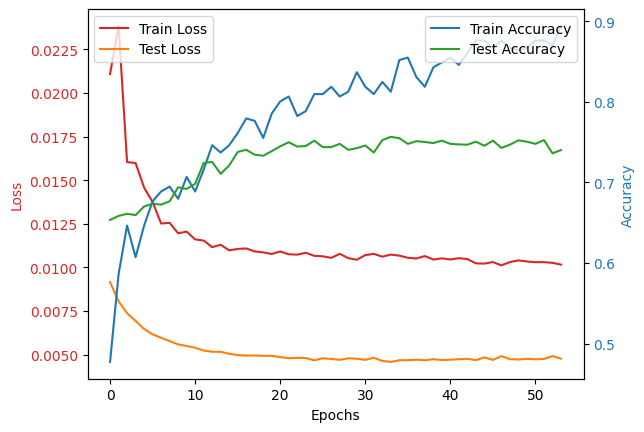

Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.01017855601047257, average accuracy 91.86182797655881
Test: Average loss 0.00504050415402362, average accuracy 75.05858048417446


In [ ]:
## Train k-fold crossvalidated model transferred, 1 -> 12 lead data
## Transfer adds new fc layer as well as allowing intermediate connections between LSTM1 and LSTM2

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.k=10
trainparams.m=9
trainparams.early_stopping=20

history = train_kfold_transfer_model(dataset_12lead, trainparams, TransferAdaptersLSTMModel, buffer=buffer, test=False)

plot_tt_graph(history, idx=0)
display_results(history, trainparams=trainparams)

Fold 1
Epoch:10/200 AVG Training Loss:0.00887 AVG Test Loss:0.00621 AVG Training Acc 62.24 % AVG Test Acc 64.35 %
Epoch:20/200 AVG Training Loss:0.00737 AVG Test Loss:0.00568 AVG Training Acc 68.88 % AVG Test Acc 67.06 %
Epoch:30/200 AVG Training Loss:0.00651 AVG Test Loss:0.00527 AVG Training Acc 74.92 % AVG Test Acc 68.97 %
Epoch:40/200 AVG Training Loss:0.00586 AVG Test Loss:0.00527 AVG Training Acc 77.04 % AVG Test Acc 70.14 %
Epoch:50/200 AVG Training Loss:0.00512 AVG Test Loss:0.00537 AVG Training Acc 84.59 % AVG Test Acc 70.10 %
Epoch:60/200 AVG Training Loss:0.00502 AVG Test Loss:0.00492 AVG Training Acc 86.71 % AVG Test Acc 73.02 %
Epoch:70/200 AVG Training Loss:0.00487 AVG Test Loss:0.00500 AVG Training Acc 86.40 % AVG Test Acc 73.38 %
Epoch:80/200 AVG Training Loss:0.00434 AVG Test Loss:0.00515 AVG Training Acc 91.24 % AVG Test Acc 72.82 %
Early stopping triggered after epoch 87
Fold 2
Epoch:10/200 AVG Training Loss:0.00872 AVG Test Loss:0.00617 AVG Training Acc 67.37 % AVG 

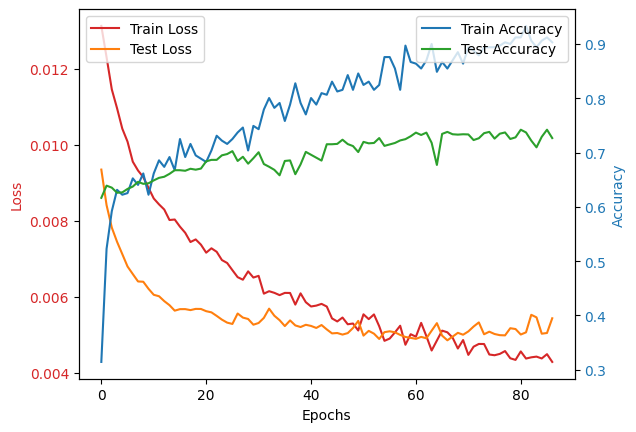

Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.0048697439999856, average accuracy 89.78460670476468
Test: Average loss 0.005758168469717858, average accuracy 73.13300704033173


In [ ]:
## Train k-fold crossvalidated model transferred, 1 -> 12 lead data
## Transfer adds new fc layer and new LSTM layer

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.n_epochs=200
trainparams.k=10
trainparams.m=9
trainparams.early_stopping=20

history = train_kfold_transfer_model(dataset_12lead, trainparams, Transfer1LSTMModel, buffer=buffer, test=False)

plot_tt_graph(history, idx=0)
display_results(history, trainparams=trainparams)

In [ ]:
## Train k-fold crossvalidated model transferred, 1 -> 12 lead data

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.k=10
trainparams.m=9
trainparams.early_stopping=20


for base_decay in [0.00001 * 2 ** i for i in range(10)]:
    trainparams.base_decay = base_decay

    history = train_kfold_transfer_model(dataset_12lead, trainparams, Transfer1LSTMModel, buffer=buffer, test=False, verbose=False)

    # plot_tt_graph(history, idx=0)

    print(f'\n\n\n##### decay rate {base_decay}')
    display_results(history, trainparams=trainparams)




##### decay rate 1e-05
Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.0031394222757836323, average accuracy 92.2543042259673
Test: Average loss 0.005575405785830426, average accuracy 75.34325793553714



##### decay rate 2e-05
Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.00365060051937096, average accuracy 92.10397481163325
Test: Average loss 0.0056262301620364705, average accuracy 75.40019813476168



##### decay rate 4e-05
Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.003943431980226399, average accuracy 93.4603974811633
Test: Average loss 0.005629858633990846, average accuracy 75.86563207253761



##### decay rate 8e-05
Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.00436789161980497, average accuracy 92.49444909547556
Test: Average loss 0.005634408243827259, average accuracy 74.37203658362394



##### decay rate 0.00016
Overall result

## Augmented Data

In [ ]:
control_dataset = WindowDataset(data_1lead, labelmap, device=device, trim_samples=1000)

8528it [00:03, 2480.05it/s]


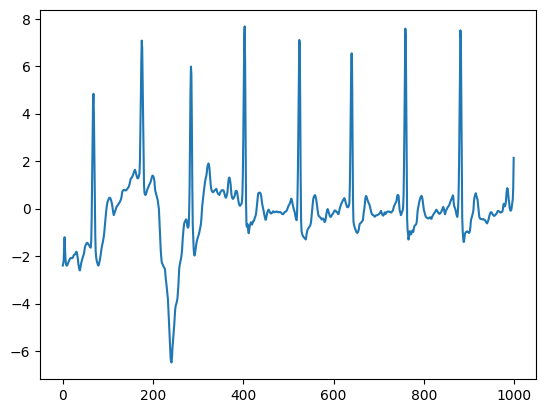

In [ ]:
waveform, label, rpeaks = control_dataset.__getitem__(0, return_rpeaks=True)
plt.plot(waveform.cpu())

In [ ]:
augment_dataset = AugmentDataset(data_1lead, labelmap, device=device, trim_samples=1000)

8528it [00:03, 2276.40it/s]


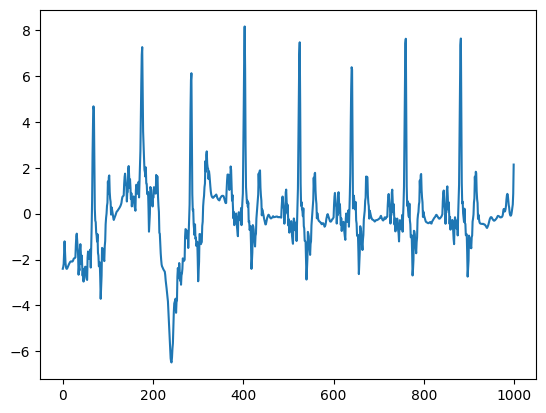

In [ ]:
waveform, label = augment_dataset.__getitem__(0)
plt.plot(waveform[:,4].cpu())

In [ ]:
augment_dataset.__getitem__(0)[0].shape

torch.Size([1000, 12])

8528it [00:03, 2341.29it/s]


Fold 1
Epoch:10/100 AVG Training Loss:0.00732 AVG Test Loss:0.00600 AVG Training Acc 70.42 % AVG Test Acc 69.11 %
Epoch:20/100 AVG Training Loss:0.00678 AVG Test Loss:0.00584 AVG Training Acc 71.60 % AVG Test Acc 70.87 %
Epoch:30/100 AVG Training Loss:0.00638 AVG Test Loss:0.00586 AVG Training Acc 73.94 % AVG Test Acc 71.51 %
Epoch:40/100 AVG Training Loss:0.00623 AVG Test Loss:0.00608 AVG Training Acc 74.41 % AVG Test Acc 71.44 %
Early stopping triggered after epoch 45


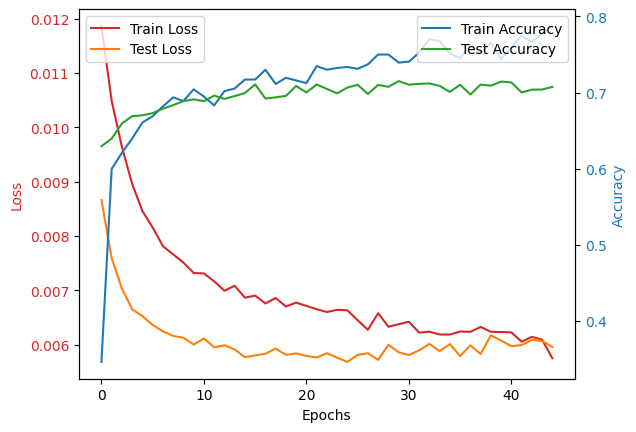

Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.005752154289276947, average accuracy 78.75586854460094
Test: Average loss 0.005959530456604095, average accuracy 71.50859822824388


In [ ]:
## Train k-fold crossvalidated model transferred, 1 -> 12 lead data

augment_dataset = AugmentDataset(data_1lead, labelmap, device=device, trim_samples=1000)

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.k=10
trainparams.m=9
trainparams.early_stopping=20

history = train_kfold_transfer_model(augment_dataset, trainparams, Transfer1LSTMModel, buffer=buffer, test=True)

plot_tt_graph(history, idx=0)
display_results(history, trainparams=trainparams)